<a href="https://colab.research.google.com/github/Shahid0120/ml-mini-projects/blob/main/transfer_learning_with_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using transfer learning through existing  MobileNet model to improve idenitifying cats and dogs data set**

Shahid Hussain 6th December 2023


In [2]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import logging
from tensorflow.keras import layers

# only error logged
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

Import MobileNet v2 model

inputs : 224 x 224 pixels images, in RBG

In [3]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

Run a image from the MobielNet v2 model


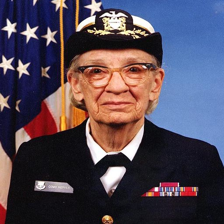

In [7]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [9]:
# batch dimension
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape


1/1 [==============================] - 0s 24ms/step


(1, 1001)

imagenet has 1001 classes

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

class 653

What is class 653

10484/10484 [==============================] - 0s 0us/step


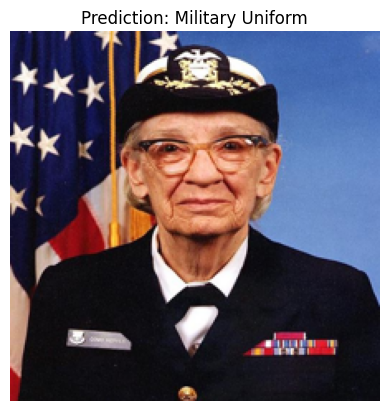

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

how does mobilenet perform on cats vs data dataset?

In [12]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteAHG51S/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [13]:
# making the images in cats and dogs the same size
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [16]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

Checking out the MobileNet model perform on existing class using the cat vs dog data set

In [17]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 615ms/step


array(['Eskimo dog', 'Maltese dog', 'Persian cat', 'mink', 'Egyptian cat',
       'bluetick', 'English setter', 'Egyptian cat', 'beagle',
       'space heater', 'paper towel', 'Labrador retriever',
       'Staffordshire bullterrier', 'tabby', 'Tibetan terrier',
       'Egyptian cat', 'German shepherd', 'basenji', 'German shepherd',
       'tiger cat', 'Shetland sheepdog', 'toy terrier', 'basset',
       'Great Dane', 'Appenzeller', 'tabby', 'Persian cat', 'Pembroke',
       'West Highland white terrier', 'Cardigan', 'Labrador retriever',
       'golden retriever'], dtype='<U30')

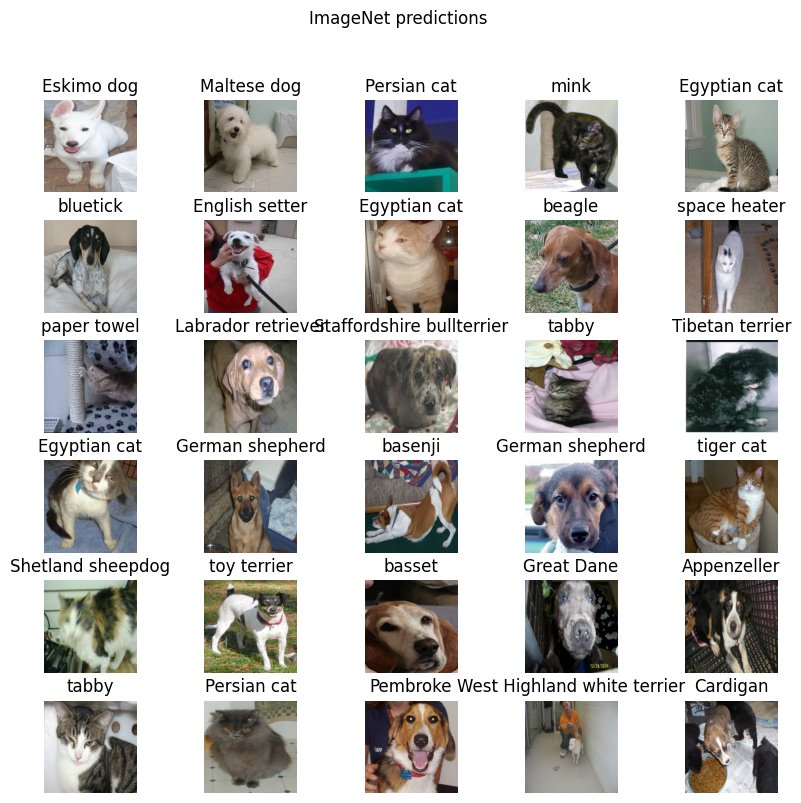

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Not so good the "dog" is not a "cardigan"
Now we have to change the output layer of the NN changing the class to dog and cat . This is done through using tensorflow hub


In [19]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [20]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [22]:
feature_extractor.trainable = False

Adding new classification layer

In [25]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation="softmax")
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# train model
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


582/582 [==============================] - 51s 71ms/step - loss: 0.0539 - accuracy: 0.9819 - val_loss: 0.0350 - val_accuracy: 0.9873
Epoch 2/6
389/582 [===================>..........] - ETA: 11s - loss: 0.0324 - accuracy: 0.9889